#**Base Model - CNN**

In [1]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (138 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import numpy as np
import os
import random

from PIL import Image
from skimage.color import rgb2gray

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score, confusion_matrix


from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/ADL Project/Image_sets_20'

Image_label_Level_3.npy  Image_label_Level_4.npy  Image_label_Level_5.npy


##**1. Load Images, masks and labels**

In [6]:
set_path = '/content/drive/My Drive/ADL Project/Image_sets_20/Image_label_Level_3.npy'
Data_set = np.load(set_path,allow_pickle=True)

In [7]:
IMG_train = np.asarray(Data_set.item()['IMG_train'])
MSK_train = np.asarray(Data_set.item()['MSK_train'])
LBL_train = np.asarray(Data_set.item()['LBL_train'])
IMG_val = np.asarray(Data_set.item()['IMG_val'])
MSK_val = np.asarray(Data_set.item()['MSK_val'])
LBL_val = np.asarray(Data_set.item()['LBL_val'])
IMG_test = np.asarray(Data_set.item()['IMG_test'])
MSK_test = np.asarray(Data_set.item()['MSK_test'])
LBL_test = np.asarray(Data_set.item()['LBL_test'])

In [8]:
del Data_set

##**2. Imbalanced Data Set**

In [9]:
print("Size for the training set:", len(IMG_train))
print("Number of labels:", len(LBL_train))
print("Number of tiles containing tumors:", sum(LBL_train))
print("Percentage of tumors in the sample:", sum(LBL_train)/len(LBL_train))

Size for the training set: 5576
Number of labels: 5576
Number of tiles containing tumors: 784
Percentage of tumors in the sample: 0.1406025824964132


In [10]:
Trainset_size = len(IMG_train)
IMG_train_reshaped = IMG_train.reshape(Trainset_size,-1)

###**a. Oversampling**

In [11]:
ROS = RandomOverSampler(random_state=42)

In [12]:
IMG_over, LBL_over = ROS.fit_resample(IMG_train_reshaped, LBL_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [13]:
print("Size for the training set:", len(IMG_over))
print("Number of labels:", len(LBL_over))
print("Number of tiles containing tumors:", sum(LBL_over))
print("Percentage of tumors in the sample:", sum(LBL_over)/len(LBL_over))

Size for the training set: 9584
Number of labels: 9584
Number of tiles containing tumors: 4792
Percentage of tumors in the sample: 0.5


In [14]:
IMG_over = IMG_over.reshape((len(IMG_over), 256, 256, 3))

###**b. Undersampling**

In [15]:
RUS = RandomUnderSampler(random_state=42)

In [16]:
IMG_under, LBL_under = RUS.fit_resample(IMG_train_reshaped, LBL_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [17]:
print("Size for the training set:", len(IMG_under))
print("Number of labels:", len(LBL_under))
print("Number of tiles containing tumors:", sum(LBL_under))
print("Percentage of tumors in the sample:", sum(LBL_under)/len(LBL_under))

Size for the training set: 1568
Number of labels: 1568
Number of tiles containing tumors: 784
Percentage of tumors in the sample: 0.5


In [18]:
IMG_under = IMG_under.reshape((len(IMG_under), 256, 256, 3))

In [19]:
#del IMG_train, IMG_train_reshaped

##**3. Data Augmentation**

In [20]:
BATCH_SIZE = 256

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip = True, rotation_range=20, width_shift_range=0.2,height_shift_range=0.2) #rotation_range=20, width_shift_range=0.2,height_shift_range=0.2, brightness_range=[0.2,1.0]
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(IMG_train, LBL_train, batch_size=BATCH_SIZE, shuffle=True)
train_generator_over = train_datagen.flow(IMG_over, LBL_over, batch_size=BATCH_SIZE, shuffle=True)
train_generator_under = train_datagen.flow(IMG_under, LBL_under, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(IMG_val, LBL_val, batch_size=BATCH_SIZE, shuffle=True)
test_generator = train_datagen.flow(IMG_test, LBL_test, batch_size=32, shuffle=True)

##**4. Base Model - CNN**

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.Recall(), tf.keras.metrics.Precision(),'accuracy']) # metrics=['accuracy'] , [tf.keras.metrics.AUC()] tf.keras.metrics.Precision() [tf.keras.metrics.Recall()]

In [36]:
history = model.fit(train_generator_under, epochs=10, 
                    validation_data=val_generator)  # Try train_generator_under and train_generator_over

Epoch 1/10
7/7 [==============================] - 41s 6s/step - loss: 0.3962 - auc: 0.9248 - recall: 0.8036 - precision: 0.8962 - accuracy: 0.8552 - val_loss: 0.3042 - val_auc: 0.8645 - val_recall: 0.3673 - val_precision: 0.7059 - val_accuracy: 0.8895
Epoch 2/10
7/7 [==============================] - 37s 5s/step - loss: 0.4187 - auc: 0.9049 - recall: 0.8393 - precision: 0.8329 - accuracy: 0.8355 - val_loss: 0.5403 - val_auc: 0.8367 - val_recall: 0.8520 - val_precision: 0.3025 - val_accuracy: 0.7030
Epoch 3/10
7/7 [==============================] - 35s 6s/step - loss: 0.4986 - auc: 0.8665 - recall: 0.8367 - precision: 0.7664 - accuracy: 0.7908 - val_loss: 0.3305 - val_auc: 0.8948 - val_recall: 0.7704 - val_precision: 0.5033 - val_accuracy: 0.8608
Epoch 4/10
7/7 [==============================] - 36s 5s/step - loss: 0.4515 - auc: 0.8839 - recall: 0.8227 - precision: 0.8144 - accuracy: 0.8176 - val_loss: 0.2800 - val_auc: 0.8682 - val_recall: 0.4745 - val_precision: 0.6739 - val_accuracy:

Text(0.5, 0, 'epochs')

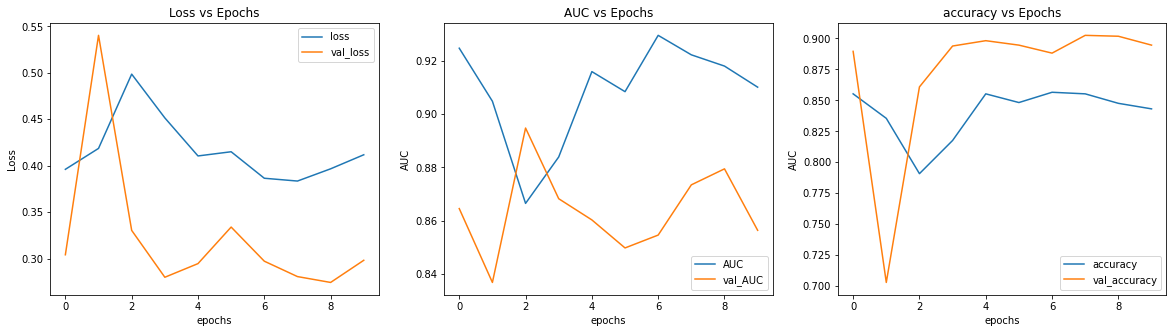

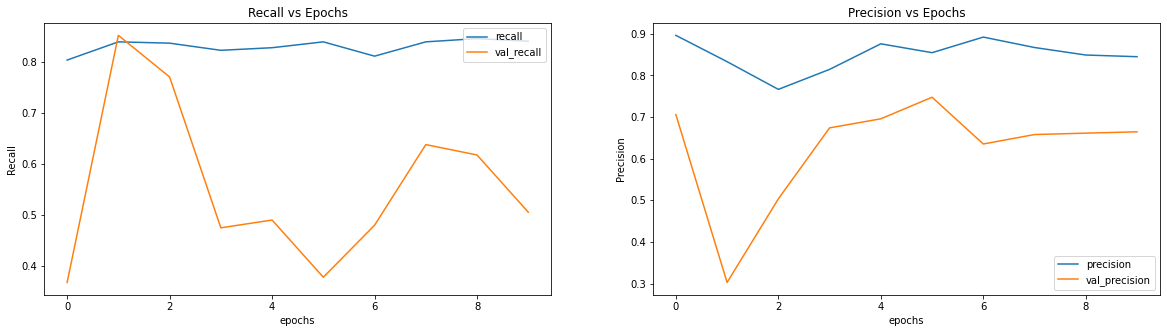

In [37]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))

ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label = 'val_loss')
ax[0].legend(loc='upper right')
ax[0].set_title('Loss vs Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epochs')

ax[1].plot(history.history['auc'], label='AUC')
ax[1].plot(history.history['val_auc'], label = 'val_AUC')
ax[1].legend(loc='lower right')
ax[1].set_title('AUC vs Epochs')
ax[1].set_ylabel('AUC')
ax[1].set_xlabel('epochs')


ax[2].plot(history.history['accuracy'], label='accuracy')
ax[2].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[2].legend(loc='lower right')
ax[2].set_title('accuracy vs Epochs')
ax[2].set_ylabel('AUC')
ax[2].set_xlabel('epochs')


fig, ax = plt.subplots(1,2, figsize=(20, 5))

ax[0].plot(history.history['recall'], label='recall')
ax[0].plot(history.history['val_recall'], label = 'val_recall')
ax[0].legend(loc='upper right')
ax[0].set_title('Recall vs Epochs')
ax[0].set_ylabel('Recall')
ax[0].set_xlabel('epochs')

ax[1].plot(history.history['precision'], label='precision')
ax[1].plot(history.history['val_precision'], label = 'val_precision')
ax[1].legend(loc='lower right')
ax[1].set_title('Precision vs Epochs')
ax[1].set_ylabel('Precision')
ax[1].set_xlabel('epochs')


In [38]:
test_loss, test_auc, test_rec, test_prec, test_acc = model.evaluate(test_generator)
print('Test loss: %.3f, AUC: %.3f, Recall: %.3f, Precision: %.3f, Accuracy: %.3f ' %(test_loss, test_auc, test_rec, test_rec, test_acc))

53/53 [==============================] - 24s 458ms/step - loss: 0.2974 - auc: 0.8060 - recall: 0.4839 - precision: 0.1500 - accuracy: 0.8793
Test loss: 0.297, AUC: 0.806, Recall: 0.484, Precision: 0.484, Accuracy: 0.879 


In [39]:
path_save = os.getcwd() + '/drive/My Drive/ADL Project/model'
path_save

'/content/drive/My Drive/ADL Project/model'

In [40]:
model_filename = os.path.join(path_save, 'base_model_3_20_under.h5' )
model.save(model_filename)